In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
import os 
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 


In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,Resizing,Rescaling,Layer,RandomContrast,RandomFlip,RandomRotation,RandomZoom,RandomCrop,InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint,CSVLogger,TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,InputLayer,GlobalAveragePooling2D,Dropout,Activation,Add,Input
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy

In [11]:
train_dir = r"human-emotions-dataset\Emotions Dataset\Emotions Dataset\train"
val_dir = r"human-emotions-dataset\Emotions Dataset\Emotions Dataset\test"
CLASS_NAME = ["angry","happy","sad"]


In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
) 

Found 6799 files belonging to 3 classes.


In [13]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
) 

Found 2278 files belonging to 3 classes.


In [15]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[252.       , 252.       , 252.       ],
         [251.69922  , 251.69922  , 251.69922  ],
         [247.83203  , 247.83203  , 247.83203  ],
         ...,
         [221.6211   , 221.6211   , 221.6211   ],
         [221.97266  , 221.97266  , 221.97266  ],
         [222.       , 222.       , 222.       ]],

        [[251.48047  , 251.48047  , 251.48047  ],
         [251.18343  , 251.18343  , 251.18343  ],
         [247.3643   , 247.3643   , 247.3643   ],
         ...,
         [221.89314  , 221.89314  , 221.89314  ],
         [222.67729  , 222.67729  , 222.67729  ],
         [222.73828  , 222.73828  , 222.73828  ]],

        [[244.80078  , 244.80078  , 244.80078  ],
         [244.5518   , 244.5518   , 244.5518   ],
         [241.35066  , 241.35066  , 241.35066  ],
         ...,
         [225.39091  , 225.39091  , 225.39091  ],
         [231.7369   , 231.7369   , 231.7369   ],
         [232.23047  , 232.23047  , 232.2304

## DATA VISUALZATION
    

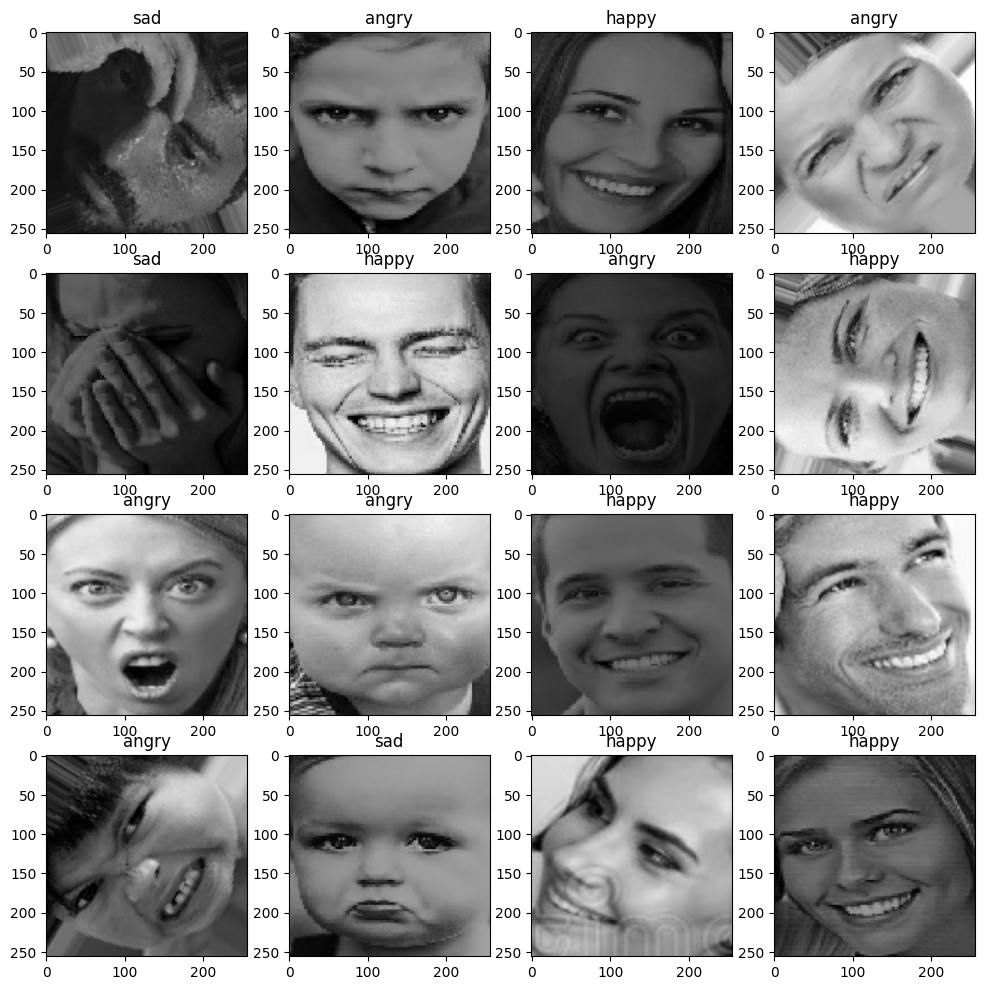

In [16]:
plt.figure(figsize=(12,12))
for image,label in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i]/255.0)

        plt.title(CLASS_NAME[tf.argmax(label[i],axis = 0).numpy()])
        # plt.axis('off')

In [17]:
train_dataset= (train_dataset.prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset.prefetch(tf.data.AUTOTUNE))

#### Resizicing and rescaling layers


In [19]:
# resize_rescale_layer = Sequential([
#     Resizing(CONFIGS['IM_SIZE'], CONFIGS['IM_SIZE']),
#     Rescaling(1./255)
# ])

### MODEL TRAINING 


In [20]:
CONFIGS = {
    "BATCH_SIZE":32,
    "IM_SIZE": 256,
    "N_FILTERS": 32,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS":20,
    "DROPOUT_RATE": 0.0,
    "KERNEL_SIZE": 3,
    "N_FILTERS": 6,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_UNITS_1": 100,
    "N_DENSE_UNITS_2": 10,
    "N_CLASSES": 3,
    "REGULARIZER_RATE": 0.001,
    "LOSS": CategoricalCrossentropy(),
    "OPTIMIZER": Adam(learning_rate=0.001),
    "METRICS": ['accuracy']
}

In [21]:
lenet_model_builder = Sequential([
    InputLayer(input_shape = (CONFIGS['IM_SIZE'], CONFIGS['IM_SIZE'], 3)),
    Resizing(CONFIGS['IM_SIZE'], CONFIGS['IM_SIZE']),
    Rescaling(1./255),
    Conv2D(filters = CONFIGS['N_FILTERS'], kernel_size = CONFIGS['KERNEL_SIZE'],strides=CONFIGS['N_STRIDES'], activation = 'relu', padding = 'same', kernel_regularizer = L2(CONFIGS['REGULARIZER_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGS['POOL_SIZE'], strides=CONFIGS['N_STRIDES']*2),
    Dropout(rate=CONFIGS['DROPOUT_RATE']),
    Conv2D(filters = CONFIGS['N_FILTERS']*2+4, kernel_size = CONFIGS['KERNEL_SIZE'], strides=CONFIGS['N_STRIDES'], activation = 'relu', padding = 'same', kernel_regularizer = L2(CONFIGS['REGULARIZER_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGS['POOL_SIZE'], strides=CONFIGS['N_STRIDES']*2),
    Flatten(),
    
    Dense(units = CONFIGS['N_DENSE_UNITS_1'],activation='relu',kernel_regularizer=L2(CONFIGS['REGULARIZER_RATE'])),

    BatchNormalization(),
    Dropout(rate=CONFIGS['DROPOUT_RATE']),

    Dense(units = CONFIGS['N_DENSE_UNITS_2'],activation='relu',kernel_regularizer=L2(CONFIGS['REGULARIZER_RATE'])),

    BatchNormalization(),

    Dense(units = CONFIGS["N_CLASSES"], activation='softmax', kernel_regularizer=L2(CONFIGS['REGULARIZER_RATE']))
])

c:\projects\HumanEmotionsPred\HumanEmo\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [22]:
lenet_model_builder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     6,553,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,556,319 (25.01 MB)

 Trainable params: 6,556,055 (25.01 MB)

 Non-trainable params: 264 (1.03 KB)

In [23]:
loss_func = CONFIGS['LOSS']
loss_func

<LossFunctionWrapper(<function categorical_crossentropy at 0x000001F745D7EFC0>, kwargs={'from_logits': False, 'label_smoothing': 0.0, 'axis': -1})>

In [25]:
metrics = [CategoricalAccuracy(name='accuracy'),TopKCategoricalAccuracy(k = 2,name='top_k_accuracy')]

In [26]:
lenet_model_builder.compile(
    optimizer=CONFIGS['OPTIMIZER'], 
    loss=loss_func,
    metrics=metrics
)

In [27]:
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
lenet_model_builder.fit(
    train_dataset,validation_data = val_dataset,
    epochs = CONFIGS['N_EPOCHS'],
    verbose = 1,
    callbacks=[
        earlystop
    ]
)

Epoch 1/20


213/213 ━━━━━━━━━━━━━━━━━━━━ 89s 390ms/step - accuracy: 0.5349 - loss: 1.3801 - top_k_accuracy: 0.8059 - val_accuracy: 0.2643 - val_loss: 1.7542 - val_top_k_accuracy: 0.5347
Epoch 2/20
208/213 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step - accuracy: 0.6617 - loss: 1.1482 - top_k_accuracy: 0.8711

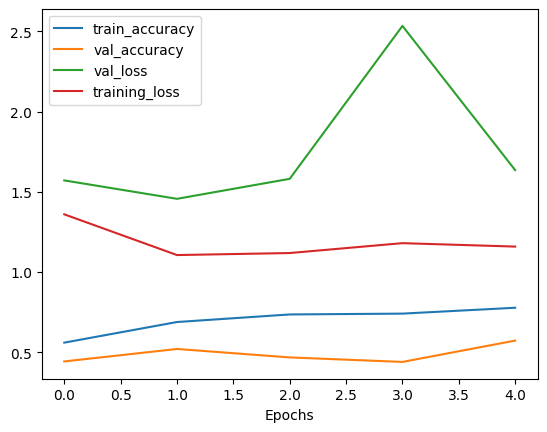

In [63]:
plt.plot(lenet_model_builder.history.history['accuracy'], label='train_accuracy')
plt.plot(lenet_model_builder.history.history['val_accuracy'], label='val_accuracy')
plt.plot(lenet_model_builder.history.history['val_loss'], label='val_loss')
plt.plot(lenet_model_builder.history.history['loss'], label='training_loss')

plt.xlabel('Epochs')   
plt.legend()

In [64]:
lenet_model_builder.evaluate(val_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.5198 - loss: 1.4559 - top_k_accuracy: 0.7858


[1.4558768272399902, 0.51975417137146, 0.7857769727706909]

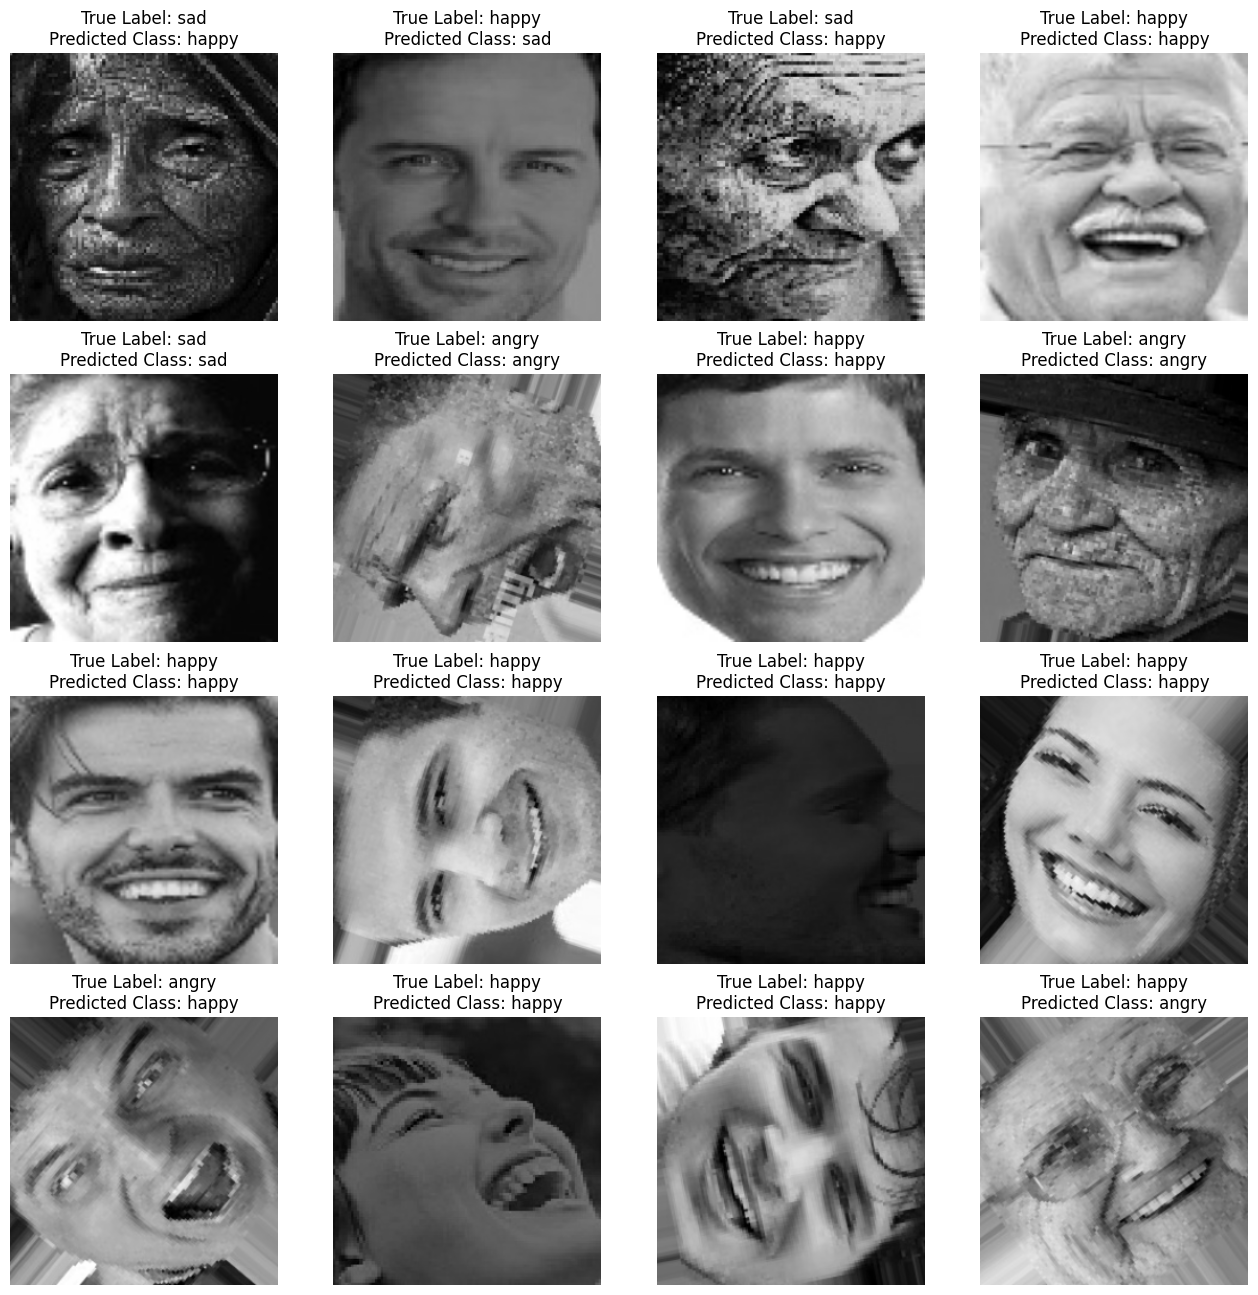

In [ ]:
plt.figure(figsize=(16,16))

for image, label in val_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i] / 255.0)

        # True label
        true_class = CLASS_NAME[int(tf.argmax(label[i], axis=0))]

        # Model prediction (add batch dimension)
        preds = lenet_model_builder(tf.expand_dims(image[i], axis=0), training=False)
        pred_class = CLASS_NAME[int(tf.argmax(preds, axis=1))]

        plt.title(f"True Label: {true_class}\nPredicted Class: {pred_class}")
        plt.axis("off")


In [82]:
predicted = []
labels = []

for image,label in val_dataset:
    predicted.append(lenet_model_builder(image,training = False)) 
    labels.append(label.numpy())   


In [95]:
print(np.argmax(labels[:-1], axis=-1).flatten())
print(np.argmax(predicted[:-1], axis=-1).flatten())

[0 0 1 ... 2 0 2]
[2 1 2 ... 1 2 2]


In [96]:
preds = np.argmax(predicted[:-1], axis=-1).flatten()
labels = np.argmax(labels[:-1], axis=-1).flatten()


In [97]:
from sklearn.metrics import confusion_matrix

Text(0.5, 23.52222222222222, 'Predicted')

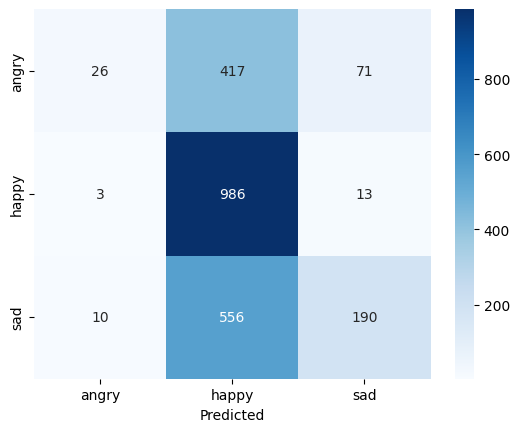

In [ ]:
cm = confusion_matrix(labels, preds)
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAME, yticklabels=CLASS_NAME)
plt.xlabel('Predicted')

In [105]:
augment_layers = Sequential([
    RandomFlip(mode = "horizontal"),
    RandomRotation(factor =(0.25,0.25)),
    RandomContrast(0.1),
])

def augument_data(image,label):
    return augment_layers(image,training = True),label

In [106]:
###DATA AUGMENTATION

train_dataset = (
    train_dataset.map(augument_data,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
)

In [114]:
lenet_model_aug = Sequential([
    InputLayer(input_shape = (CONFIGS['IM_SIZE'], CONFIGS['IM_SIZE'], 3)),
    Resizing(CONFIGS['IM_SIZE'], CONFIGS['IM_SIZE']),
    Rescaling(1./255),
    Conv2D(filters = CONFIGS['N_FILTERS'], kernel_size = CONFIGS['KERNEL_SIZE'],strides=CONFIGS['N_STRIDES'], activation = 'relu', padding = 'same', kernel_regularizer = L2(CONFIGS['REGULARIZER_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGS['POOL_SIZE'], strides=CONFIGS['N_STRIDES']*2),
    Dropout(rate=CONFIGS['DROPOUT_RATE']),
    Conv2D(filters = CONFIGS['N_FILTERS']*2+4, kernel_size = CONFIGS['KERNEL_SIZE'], strides=CONFIGS['N_STRIDES'], activation = 'relu', padding = 'same', kernel_regularizer = L2(CONFIGS['REGULARIZER_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGS['POOL_SIZE'], strides=CONFIGS['N_STRIDES']*2),
    Flatten(),
    
    Dense(units = CONFIGS['N_DENSE_UNITS_1'],activation='relu',kernel_regularizer=L2(CONFIGS['REGULARIZER_RATE'])),

    BatchNormalization(),
    Dropout(rate=CONFIGS['DROPOUT_RATE']),

    Dense(units = CONFIGS['N_DENSE_UNITS_2'],activation='relu',kernel_regularizer=L2(CONFIGS['REGULARIZER_RATE'])),

    BatchNormalization(),

    Dense(units = CONFIGS["N_CLASSES"], activation='softmax', kernel_regularizer=L2(CONFIGS['REGULARIZER_RATE']))
])

lenet_model_aug.compile(
    optimizer=Adam(learning_rate=CONFIGS["LEARNING_RATE"]), 
    loss=loss_func,
    metrics=metrics,
    run_eagerly=True
)

In [115]:
lenet_model_aug.fit(
    train_dataset,validation_data = val_dataset,
    epochs = CONFIGS['N_EPOCHS'],
    verbose = 1,
    callbacks=[
        earlystop
    ]
)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 166s 773ms/step - accuracy: 0.5321 - loss: 1.3923 - top_k_accuracy: 0.7971 - val_accuracy: 0.4118 - val_loss: 1.5204 - val_top_k_accuracy: 0.7739
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 180s 840ms/step - accuracy: 0.6460 - loss: 1.1940 - top_k_accuracy: 0.8713 - val_accuracy: 0.4421 - val_loss: 1.6236 - val_top_k_accuracy: 0.7691
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 147s 685ms/step - accuracy: 0.6885 - loss: 1.1201 - top_k_accuracy: 0.8956 - val_accuracy: 0.4662 - val_loss: 1.5294 - val_top_k_accuracy: 0.7695
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 173s 808ms/step - accuracy: 0.6723 - loss: 1.2605 - top_k_accuracy: 0.8838 - val_accuracy: 0.4359 - val_loss: 1.7200 - val_top_k_accuracy: 0.7423


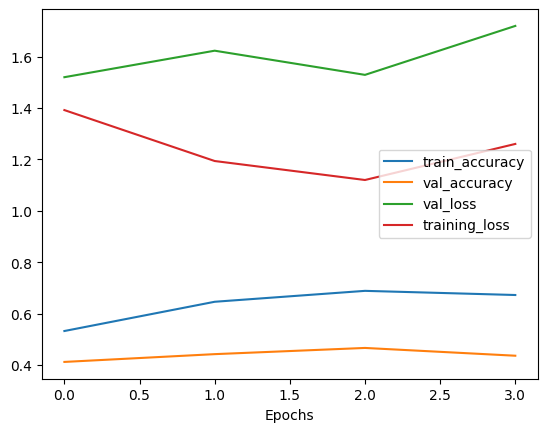

In [117]:
plt.plot(lenet_model_aug.history.history['accuracy'], label='train_accuracy')
plt.plot(lenet_model_aug.history.history['val_accuracy'], label='val_accuracy')
plt.plot(lenet_model_aug.history.history['val_loss'], label='val_loss')
plt.plot(lenet_model_aug.history.history['loss'], label='training_loss')

plt.xlabel('Epochs')   
plt.legend()